## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2023.

# ECBM E4040 - Assignment 2 - Task 4: Data Augmentation & Transfer Learning 

Important factors in neural network training include the size and quality of the training set. Since it is often not possible to get a clean and large enough dataset for training, one way to improve the network's robustness and generalization ability is to create '*fake*' data by injecting random noise or to perform transformations on the available data. A technique which implements this strategy is called __data augmentation__ and has shown to be very effective.

One thing to remember when you augment your data is to never change the correct label of a sample. For example, for hand-written digit dataset, rotating a letter '6' ends up looking like a letter '9', but you must keep the label for '6'. So rotation might not be the ideal augmentation technique for this task. It is important to choose wisely the best augmentation methods for your dataset.

In the last part of this task, we introduce __transfer learning__ in TensorFlow to you by showing a demo. Test time augmentation (TTA) as additional content in data augmentation is also introduced based on your experiences on previous parts.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import modules
import numpy as np
import os

try:
    import pandas as pd
except ModuleNotFoundError:
    os.system('pip install pandas')
    import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

## Load Data
For this assignment, you will work with the Fashion-MNIST dataset provided by Zalando. This dataset serves as a drop-in replacement for the original MNIST dataset, offering a more challenging alternative for benchmarking machine learning algorithms.

The dataset comprises 60,000 training examples and 10,000 testing examples. Each example in the dataset is a 28x28 grayscale image, associated with a label from one of the 10 classes, each representing a different article of clothing. The 10 classes are as follows:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

![image](https://www.researchgate.net/publication/346405197/figure/fig3/AS:962581560848384@1606508736352/Examples-of-Fashion-MNIST-dataset.ppm)

### Dataset Details:
- Each image is 28 pixels in height and 28 pixels in width, resulting in a total of 784 pixels.
- Each pixel holds an integer value between 0 and 255, representing the pixel's lightness or darkness, with higher numbers indicating darker pixels.
- The dataset is split into training and test sets, with 785 columns in each set. The first column contains class labels representing the article of clothing, while the remaining 784 columns hold the pixel values of the associated image.
### Understanding the Data:
To locate a pixel in the image, suppose you have decomposed x into x = i * 28 + j, where i and j are integers ranging from 0 to 27. The pixel can then be located on row i and column j of a 28x28 matrix. For instance, pixel31 refers to the pixel situated in the fourth column from the left and the second row from the top.

### Data Source and Acknowledgements:
- The original Fashion-MNIST dataset can be downloaded from [Zalando's GitHub repository](https://github.com/zalandoresearch/fashion-mnist).
- The dataset was converted to CSV format using a [script provided by pjreddie](https://pjreddie.com/projects/mnist-in-csv/).


In [2]:
# Load the Fashion MNIST data.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 50000 samples from original train set: 1~60000
# Validation data: 10000 samples from original train set: 50001~60000
# Test data: 10000 samples

num_train = 50000
num_valid = 10000
num_test = 10000
num_dev = 256

X_train = X_train.reshape(num_train+num_valid, -1)
X_test = X_test.reshape(num_valid,-1)

# The development set is used for augmentation practices.
mask = np.random.choice(num_train, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Seperate Training set into a training set and a validation set
X_val = X_train[num_train:]
y_val = y_train[num_train:]
X_train = X_train[:num_train]
y_train = y_train[:num_train]

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

print("Number of classes: {}".format(len(set(y_train))))

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)
(50000, 784) (10000, 784) (10000, 784) (256, 784)
Number of classes: 10


## Part 1: Visualization

### Visualize some original images

Here we use Pyplot to draw any 16 samples from the __development set__ in a 4-by-4 grid.

__Note__: Since we have vectorized our data, we need to reshape it into 28 x 28 greyscale images.

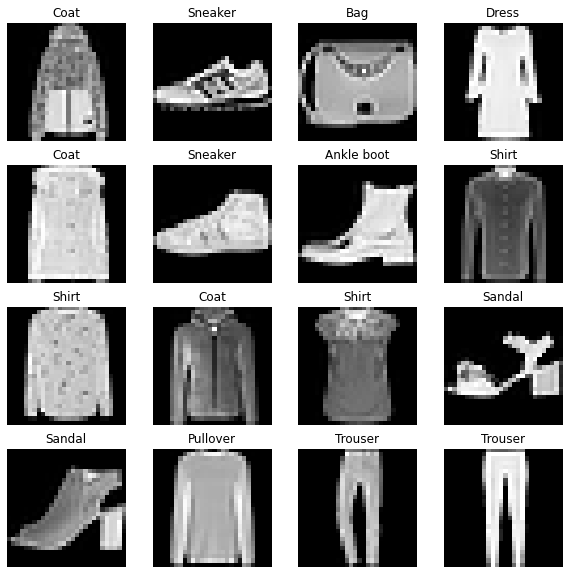

In [3]:
# Visualization of the original data.

def plot(X, y, names, shape):
    fig = plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1)
        ax.imshow(X[i, :].reshape(shape), 'gray')
        ax.set_title(names[int(y[i])])
        ax.axis('off')

names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
plot(X_dev, y_dev, names, (28, 28))

## Part 2: Automatic Batch Generator (5%)

We want you to create an automatic image generator that does several kinds of data augmentations, and produces a batch of data consisting of random samples every time you call it. 

<span style="color:red">__TODO__:</span> Finish the functions of class __ImageGenerator__ in **utils/image_generator.py**. The code is fully commented with instructions.

__Hint__: The python keywords __yield__ and __next__ can help you do some tricks.

In [4]:
from utils.image_generator import ImageGenerator

Create an ImageGenerator object using the __development set__, and use __show__ function to plot the top 16 original images.

__Note__: We need to reshape your data as the demanding input format of the class __ImageGenerator__.

In [5]:
print(X_dev.shape)
print(X_dev.reshape(-1,1,28,28).transpose(0,2,3,1).shape)

(256, 784)
(256, 28, 28, 1)


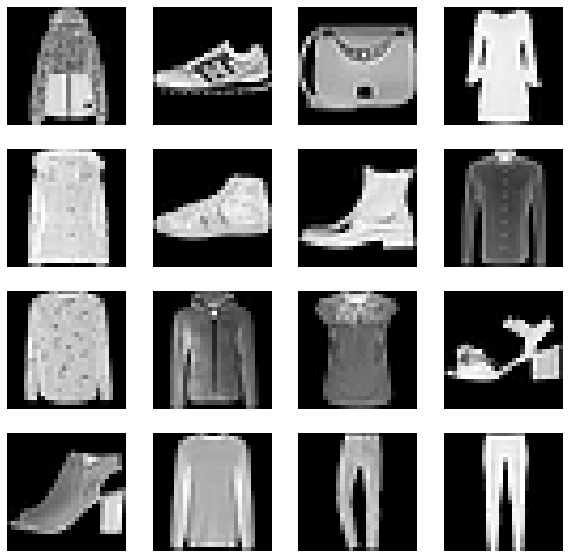

In [6]:
X_dev_reshaped = X_dev.reshape(-1, 28, 28, 1)
gen = ImageGenerator(X_dev_reshaped, y_dev)
gen.show(X_dev_reshaped)

### Add Noise (Demo)

Inject random noise into the original __development set__, and plot 16 images with noise added. 

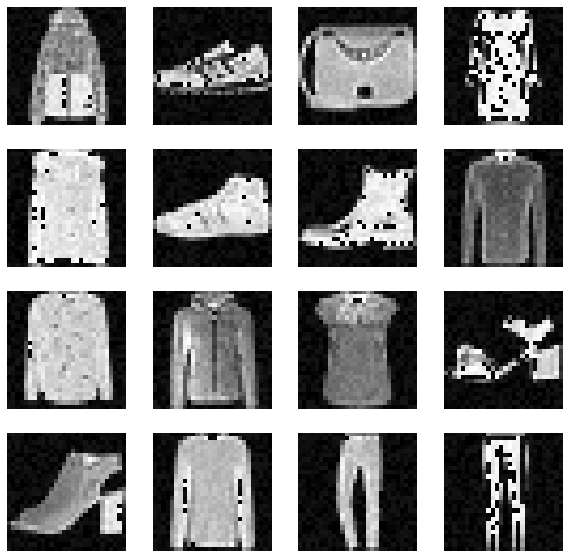

In [7]:
added = gen.add_noise(1, 5)
gen.show(added)

### Rotate (Demo)

Rotate the original __development set__ by several degrees and plot the top 16 images.

Currrent rotation:  -90


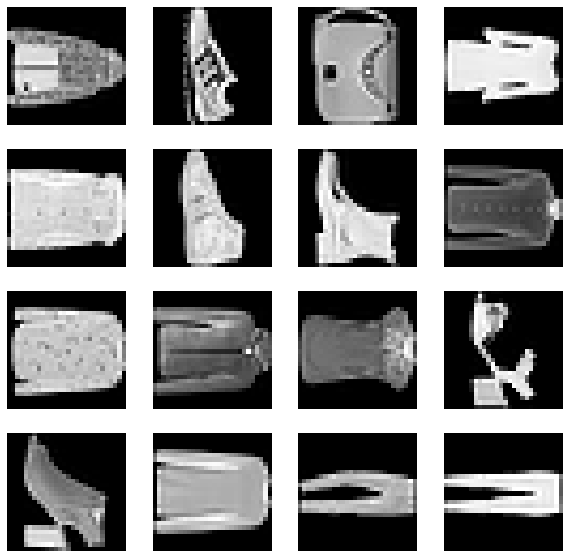

In [8]:
rotated = gen.rotate(-90)
gen.show(rotated)

### Translation

<span style="color:red">__TODO:__</span> Implement the function **translate()** in **utils/image_generator.py**. Shift the original __development set__ by several pixels in both directions, and plot the top 16 images.

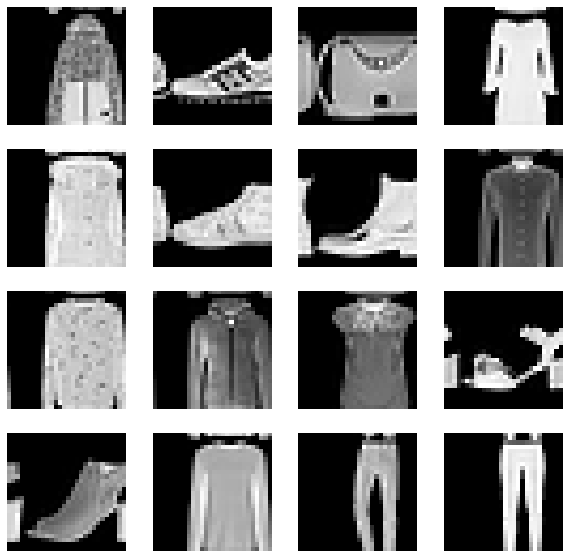

In [9]:
### TODO: Your code here ###
translate = gen.translate(2, 4)
gen.show(translate)

### Horizontal and Vertical Flip
<span style="color:red">__TODO:__</span> Implement the function **flip()** in **utils/image_generator.py**. Flip the original __development set__ as you like (horizontal, vertical, or both), and plot the top 16 images.

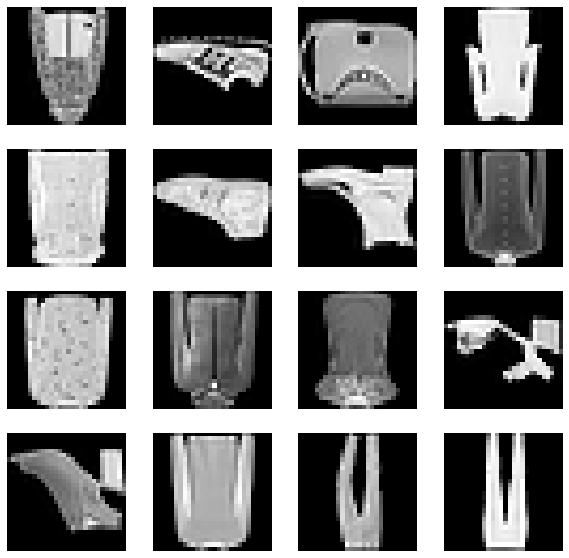

In [10]:
### TODO: Your code here ###
flipped = gen.flip('v')
gen.show(flipped)

### Increase Brightness

<span style="color:red">__TODO:__</span> Implement the function **brightness()** in **utils/image_generator.py**. Increase the brightness of the original __development set__, and plot 16 images with noise added. (These images may not be the same as the above 16 images according to your choice of parameters.)

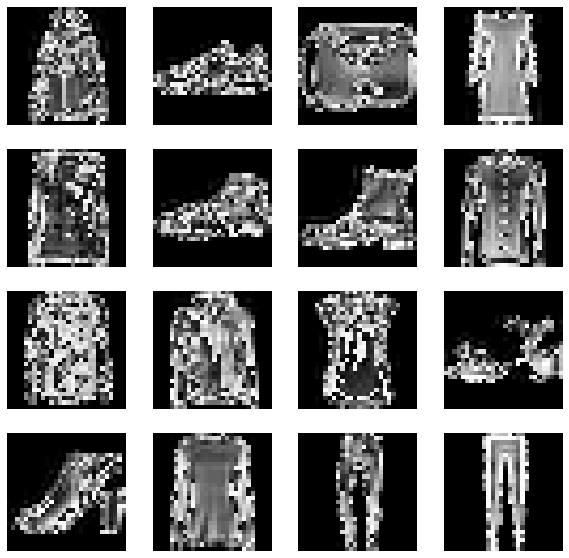

In [11]:
### TODO: Your code here ###
bright = gen.brightness(5)
gen.show(bright)


## Part 3: Data Augmentation + LeNet (5%)

<span style="color:red">__TODO__:</span> Now you have your own data generator. You have been provided a simplified LeNet model in __utils/neuralnets/cnn/model_LeNet.py__. In __utils/neuralnets/cnn/my_LeNet_trainer.py__ you will find two TODOs. 

The first TODO asks you to **prepare batches of augmented training data** using the ImageGenerator you completed in the previous section. When generating augmented data, it is important to think carefully about the changes you are making to the data and the effect those changes may have on their classification. 

For example, look at these two images of a pullover and a shirt:

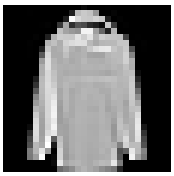

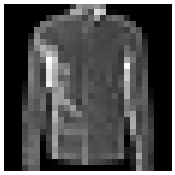

When we increase it's birghtness by a factor of 10, we are unable to differentiate between the two. This might cause issues for the classifier in context of pullovers and shirts.  

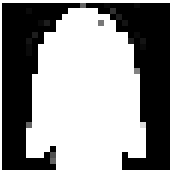

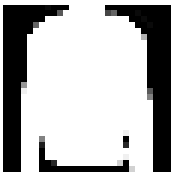

<span style="color:red">__TODO__:</span> Before completing the TODOs in __utils/neuralnets/cnn/my_LeNet_trainer.py__, explain which augmentations, or combination of augmentations (brightness, horizontal flip, vertical flip, translation, rotation, noise, etc.) could create similar issues for the classifier?

<span style="color:red">__Your answer here__:</span> A rotation augmentation and a flip (horizontal or vertical), can be interpreted as same and this could be one region of confusion.

Next we have adding to much brightness, can also result in images appearing as if they have to much noise. This can also be a point of failure.

<span style="color:red">__TODO__:</span> Propose a series of augmentations (at least 4) from the functions we implemented to generate an augmented training set. Be sure to avoid the issues discussed above and include argument parameters for the augmentation functions.

Ex:

1. flip('v')
2. brightness(1.5)
3. etc.

<span style="color:red">__Your answer here__:</span>
1. Nosie
2. Brightness
3. Translation
4. Rotation

These augmentations should be applied in a way that the resulting images still represent valid instances of the classes to be classified. For instance, the rotation should not be so extensive that the orientation of the objects becomes unrealistic (e.g., shoes or clothes that are upside down).


<span style="color:red">__TODO__:</span> Complete the function **batch_train_data()** in **utils/neuralnets/cnn/my_LeNet_trainer.py** with your proposed data augmentations.

<span style="color:red">__TODO__:</span> Complete the function **train_epoch()** in **utils/neuralnets/cnn/my_LeNet_trainer.py**.

__Install tqdm__: tqdm is a fast, extensible progress meter.

In [12]:
!pip install tqdm

In [13]:
X_t = X_train.reshape(-1,1,28,28).transpose(0,2,3,1)
X_v = X_val.reshape(-1,1,28,28).transpose(0,2,3,1)

print(X_t.shape)
print(X_v.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)


Import the LeNet Trainer

In [14]:
from utils.neuralnets.cnn.my_LeNet_trainer import MyLeNet_trainer

In [15]:
tf.keras.backend.clear_session()

<span style="color:red">__TODO__:</span> train network using run method in MyLeNet_trainer

In [16]:
# YOUR CODE HERE
epochs = 10
batch_size = 256
learning_rate = 1e-3
trainer = MyLeNet_trainer(X_t, y_train, X_v, y_val, epochs=10, batch_size=256, lr=1e-3)
trainer.run()

Currrent rotation:  15
Size of training data:150000
Training Epoch 1


100%|██████████| 585/585 [00:14<00:00, 41.77it/s] 


Loss: 0.45935678482055664, Accuracy: 84.17801666259766, Test Loss: 0.951854407787323, Test Accuracy: 71.66999816894531
Training Epoch 2


100%|██████████| 585/585 [00:05<00:00, 105.54it/s]


Loss: 0.3293921947479248, Accuracy: 88.22649383544922, Test Loss: 0.30407071113586426, Test Accuracy: 88.62000274658203
Training Epoch 3


100%|██████████| 585/585 [00:05<00:00, 104.49it/s]


Loss: 0.2807782292366028, Accuracy: 89.79967498779297, Test Loss: 0.282340943813324, Test Accuracy: 89.4800033569336
Training Epoch 4


100%|██████████| 585/585 [00:05<00:00, 100.19it/s]


Loss: 0.254875123500824, Accuracy: 90.69644927978516, Test Loss: 0.2725432515144348, Test Accuracy: 89.83000183105469
Training Epoch 5


100%|██████████| 585/585 [00:05<00:00, 100.66it/s]


Loss: 0.23693124949932098, Accuracy: 91.3094253540039, Test Loss: 0.26947563886642456, Test Accuracy: 90.06999969482422
Training Epoch 6


100%|██████████| 585/585 [00:05<00:00, 102.83it/s]


Loss: 0.21987494826316833, Accuracy: 91.87432861328125, Test Loss: 0.25806736946105957, Test Accuracy: 90.52999877929688
Training Epoch 7


100%|██████████| 585/585 [00:05<00:00, 101.85it/s]


Loss: 0.2060476541519165, Accuracy: 92.41719818115234, Test Loss: 0.2745615243911743, Test Accuracy: 90.06999969482422
Training Epoch 8


100%|██████████| 585/585 [00:05<00:00, 102.20it/s]


Loss: 0.19524915516376495, Accuracy: 92.81517028808594, Test Loss: 0.26656490564346313, Test Accuracy: 90.22000122070312
Training Epoch 9


100%|██████████| 585/585 [00:05<00:00, 100.27it/s]


Loss: 0.18597649037837982, Accuracy: 93.15705108642578, Test Loss: 0.2707776725292206, Test Accuracy: 90.38999938964844
Training Epoch 10


100%|██████████| 585/585 [00:05<00:00, 100.56it/s]

Loss: 0.17476698756217957, Accuracy: 93.63448333740234, Test Loss: 0.2622746527194977, Test Accuracy: 90.22000122070312


## Part 4 (Demos): Transfer Learning and Test Time Augmentation (TTA)

This is the last part of assignment 2 before we go to the Kaggle competition. In this part, we will provide you with examples of transfer learning, as well as the last context of data augmentation: test time augmentation. We believe they are useful tools for task 5.

__Note__: The network in demos is not guaranteed to be well-trained. __No points are set in this part__. Feel free to edit the scripts and tune the parameters by yourselves.

### Transfer Learning

The intuition behind transfer learning is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. For a somewhat different problem, you can then take advantage of these learned feature maps without having to start from scratch and training a new large model on a large dataset.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. Generally, we have two ways to customize a pre-trained model:

1. **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for our dataset. However, the final, classification part of the pretrained model is specific to original classification task, and subsequently specific to the set of classes on which the model was trained. That means you do not need to (re)train the entire model. You "freeze" the base convolution network, and only train the newly added classifier layers. 

2. **Fine-Tuning**: Unfreezing a few of the top layers of a frozen model base and jointly training both the newly-added classifier layers and the last layers of the base model. This allows us to "fine tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

This example uses the base model from __MobileNet__ for a transfer learning of a 10-class classification task on CIFAR-10 dataset. The whole pipeline will include:

1. Load data
2. Build an input pipeline, in this case using Keras ImageDataGenerator
3. Compose our model
4. Load in our pretrained base model (and pretrained weights)
5. Stack our classification layers on top
6. Train our model
7. Evaluate model

Other references: https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e

In [17]:
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [18]:
# Load the raw CIFAR-10 data.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Data organizations:
# Train data: 40000 samples from original train set: 1~40000
# Validation data: 1000 samples from original train set: 40001~50000
num_training = 40000
num_validation = 10000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

y_train_dummy = tf.keras.utils.to_categorical(y_train)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
print('Validation labels shape (one-hot): ', y_val_dummy.shape)

170500096/170498071 [==============================] - 17s 0us/step
Train data shape:  (40000, 32, 32, 3)
Train labels shape:  (40000, 1)
Validation data shape:  (10000, 32, 32, 3)
Validation labels shape:  (10000, 1)
Train labels shape (one-hot):  (40000, 10)
Validation labels shape (one-hot):  (10000, 10)


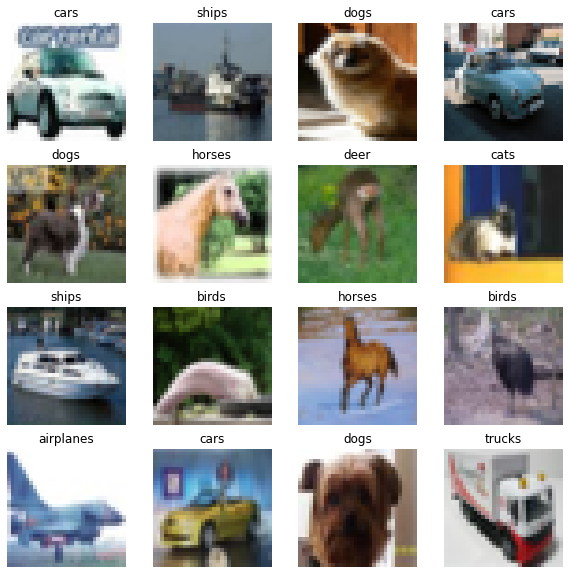

In [19]:
names = [
    'airplanes', 'cars', 'birds', 'cats', 'deer',
    'dogs', 'frogs', 'horses', 'ships', 'trucks'
]
plot(X_val, y_val, names, (32, 32, 3))

In [20]:
#imports the mobilenet model and discards the last 1000 neuron layer.
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x) # add dense layers so that the model can learn more complex functions
preds = Dense(10, activation='softmax')(x) #final layer with softmax activation

17227776/17225924 [==============================] - 2s 0us/step


In [21]:
model = Model(
    inputs=base_model.input, # specify the inputs
    outputs=preds            # specify the outputs
)
# now a model has been created based on our architecture

In [22]:
# freeze the first 20 layers
for layer in model.layers[:20]:
    layer.trainable = False
# unfreeze the layers after 20
for layer in model.layers[20:]:
    layer.trainable = True

In [23]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 16, 16, 32)        0     

In [24]:
bs = 100 #batch size
epc = 10 #number of epoches

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
train_generator = train_datagen.flow(X_train, y_train_dummy, batch_size=bs)
train_step_size = train_generator.n // train_generator.batch_size

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
valid_generator = valid_datagen.flow(X_val, y_val_dummy, batch_size=bs)

In [26]:
# train the model
history = model.fit(
    x=train_generator,
    steps_per_epoch=train_step_size,
    epochs=epc,
    validation_data=valid_generator
)

Epoch 1/10
400/400 [==============================] - 11s 20ms/step - loss: 1.3934 - accuracy: 0.5458 - val_loss: 0.8284 - val_accuracy: 0.7216
Epoch 2/10
400/400 [==============================] - 8s 19ms/step - loss: 0.6869 - accuracy: 0.7676 - val_loss: 0.7495 - val_accuracy: 0.7568
Epoch 3/10
400/400 [==============================] - 8s 19ms/step - loss: 0.5425 - accuracy: 0.8185 - val_loss: 0.7016 - val_accuracy: 0.7628
Epoch 4/10
400/400 [==============================] - 8s 20ms/step - loss: 0.4504 - accuracy: 0.8462 - val_loss: 0.7296 - val_accuracy: 0.7653
Epoch 5/10
400/400 [==============================] - 8s 19ms/step - loss: 0.3806 - accuracy: 0.8685 - val_loss: 0.6704 - val_accuracy: 0.7889
Epoch 6/10
400/400 [==============================] - 7s 19ms/step - loss: 0.3287 - accuracy: 0.8881 - val_loss: 0.6979 - val_accuracy: 0.7874
Epoch 7/10
400/400 [==============================] - 8s 19ms/step - loss: 0.2940 - accuracy: 0.9007 - val_loss: 0.6927 - val_accuracy: 0.790

In [27]:
print(f'Baseline accuracy: {model.evaluate(valid_generator)[1]}')

100/100 [==============================] - 1s 9ms/step - loss: 0.7468 - accuracy: 0.7958
Baseline accuracy: 0.795799970626831


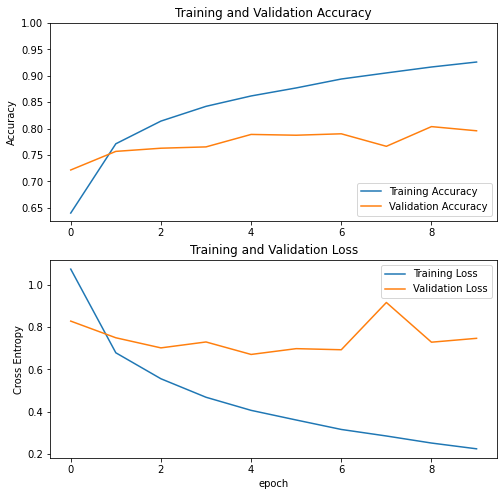

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Test Time Augmentation (TTA)

Key references: 

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

https://machinelearningmastery.com/how-to-use-test-time-augmentation-to-improve-model-performance-for-image-classification/


Data Augmentation is the process of randomly applying some operations (rotation, zoom, shift, flips, …) to the input data. By this mean, the model can learn more general features about the classes it has to recognize.

However, there also exists some ways to improve the results of the model by changing the way we test it. That is Test Time Augmentation (TTA).

TTA is now a commonly used technique in Kaggle competition on classification. Similar to what data augmentation is doing to the training set, TTA is to perform similar data modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, we will show it the augmented images several times. The final guess of each corresponding image will base on the average of the prediction results.

The reason why we refer to TTA is that, by averaging our predictions, on randomly modified images, we are also averaging the errors. The error can be big in a single vector, leading to a wrong answer, but when averaged, only the correct answer stands out. TTA is particularly useful for test images that the model is pretty unsure. The following example will show you how to apply TTA with Keras.


In [29]:
# call an ImageDataGenerator similar to training set for test set.
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=10.,
    fill_mode='reflect', 
    width_shift_range = 0.1, 
    height_shift_range = 0.1
) #included in our dependencies
test_generator = test_datagen.flow(X_val, y_val_dummy, batch_size=bs)

In [30]:
from tqdm import tqdm

# test time augmentation, we set TTA for 10 times averaging.
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(test_datagen.flow(X_val, batch_size=bs, shuffle=False), steps=len(X_val)/bs)
    predictions.append(preds)

100%|██████████| 10/10 [00:49<00:00,  4.93s/it]


In [31]:
# print final prediction results
final_pred = np.mean(predictions, axis=0)
print(f'Accuracy with TTA: {np.mean(np.equal(np.argmax(y_val_dummy, axis=-1), np.argmax(final_pred, axis=-1)))}')

Accuracy with TTA: 0.7681
